In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

Added: /Users/lsanchez/omath_mota_rulo


In [3]:
from data_scientia import config
from data_scientia.data import capacidad_hospitalaria
from data_scientia.data import municipios
from data_scientia.features import critical_peaks
from data_scientia.features import target_days_to_peak
from data_scientia.features import hospital
from data_scientia.features import train_data

In [4]:
dataset = train_data.get()
dataset.shape

(10799, 96)

In [5]:
config.VERBOSE = False

data = capacidad_hospitalaria.get()
data.shape

(17011, 15)

In [6]:
peaks_data = critical_peaks.get()
peaks_data.shape

/Users/lsanchez/omath_mota_rulo/data_scientia/features/critical_peaks.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_data.sort_values('fecha', inplace=True)


(301, 6)

In [7]:
days_to_peak_data = target_days_to_peak.get()
days_to_peak_data.shape

(10803, 22)

In [8]:
municipio_codes_dict = municipios.get_municipio_codes()

/Users/lsanchez/anaconda3/envs/data_scientia/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


# Sample a hospital

In [33]:
n_samples = 5

sample_hospitals = data[
    data['estatus_capacidad_uci'] == 'Crítica'
][
    'nombre_hospital'
].drop_duplicates().sample(
    n_samples, 
    random_state=0)

hospital_name = sample_hospitals.iloc[3]

hospital_name

'HG TACUBA'

In [34]:
data[
    data['nombre_hospital'] == hospital_name
].iloc[0]

datasetid                                           capacidad-hospitalaria
recordid                          fb773f1683adc190c688efbbada919ba9615f582
record_timestamp                          2020-11-30T16:04:15.140000+00:00
estatus_capacidad_hospitalaria                                         NaN
fecha                                                  2020-04-15 00:00:00
coordenadas                                        [19.454384, -99.191231]
institucion                                                         ISSSTE
nombre_hospital                                                  HG TACUBA
estatus_capacidad_uci                                                Media
geometry.type                                                        Point
geometry.coordinates                               [-99.191231, 19.454384]
estatus_capacidad_uci_percent                                           89
estatus_capacidad_uci_ordinal                                            2
latitude                 

In [35]:
'https://www.google.com/maps/search/@%s,%s,12z' % (
    tuple(data[
        data['nombre_hospital'] == hospital_name
    ][['latitude', 'longitude']].iloc[0].tolist())
)

'https://www.google.com/maps/search/@19.454384,-99.191231,12z'

# Get neighbor municipios covid daily cases

In [36]:
neighbor_municipios_daily_cases = hospital.get_neighbor_municipio_daily_cases(
    hospital_name, 
    max_meters=15e+3)

neighbor_municipios_daily_cases.columns = [
    municipio_codes_dict[x] for x in 
    neighbor_municipios_daily_cases.columns]


dataset_hospital = dataset[
    dataset['nombre_hospital'] == hospital_name
].set_index('fecha')

# Hospitals timeline

In [37]:
target_name = 'is_next_peak_in_15_days'

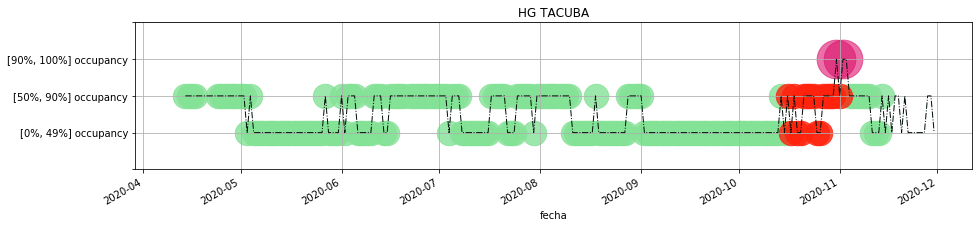

In [38]:
def plot_hospital_timeline(
    hospital_name, ax, target_name='is_next_peak_in_7_days'):
    """
    """
    color_line = '#000f08'
    color_peak = '#dc136c'
    pos_neg_class_color = {
        1: '#ff220c',
        0: '#84e296'}
    
    # Hospital timeline
    hospital_data = data[data['nombre_hospital'] == hospital_name]
    hospital_data.set_index('fecha')['estatus_capacidad_uci_ordinal'].plot(
        marker='',
        color=color_line,
        linewidth=1,
        linestyle='-.',
        markersize=3,
        grid=True,
        ax=ax)

    ax.set_title(hospital_name)
    
    # Hospital peaks
    hospital_peaks_data = peaks_data[peaks_data['nombre_hospital'] == hospital_name]
    hospital_days_to_peak_data = days_to_peak_data[
        days_to_peak_data['nombre_hospital'] == hospital_name]
    ax.scatter(
        x=hospital_peaks_data['peak_date'].apply(date2num),
        y=[3] * hospital_peaks_data.shape[0],
        s=1500,
        color=color_peak,
        alpha=.6)
    
    # Pos-Neg examples
    target_grp = hospital_days_to_peak_data.groupby(target_name)

    for is_peak_in_next_n, is_peak_in_next_n_data in target_grp:
        ax.scatter(
            x=is_peak_in_next_n_data['fecha'].apply(date2num),
            y=is_peak_in_next_n_data['estatus_capacidad_uci_ordinal'],
            s=600,
            alpha=.8,
            color=pos_neg_class_color[is_peak_in_next_n])



    ax.set_ylim(0, 4)
    
    ax.set_yticklabels([
    '',
    '[0%, 49%] occupancy', 
    '[50%, 90%] occupancy',
    '[90%, 100%] occupancy'])
    
    return ax

fig, ax = plt.subplots(1, 1, figsize=(15, 3))

_ = plot_hospital_timeline(
    hospital_name, 
    ax, 
    target_name=target_name)

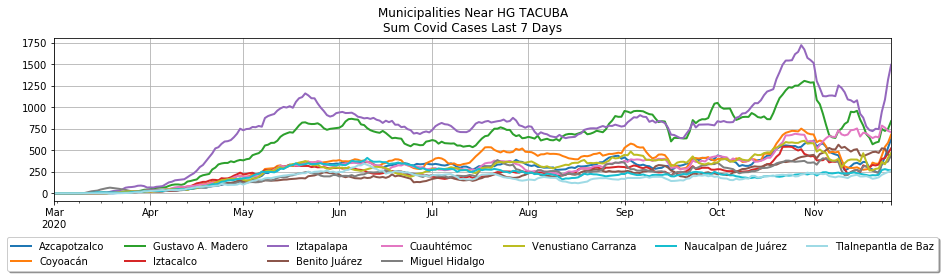

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
neighbor_municipios_daily_cases.rolling(window=7).sum().loc['2020-03-01':].plot(
    cmap='tab20',
    ax=ax,
    linewidth=2,
    title='Municipalities Near %s\nSum Covid Cases Last 7 Days' % hospital_name,
    grid=True)

ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.19),
    fancybox=True, shadow=True, ncol=7)